In [26]:
!pip install opencv-python --quiet


In [17]:
import os
import gdown

# Create directories to save the downloaded weights
os.makedirs('./saved_models/u2net', exist_ok=True)
os.makedirs('./saved_models/u2net_portrait', exist_ok=True)

# Download U2Net weights
u2net_url = 'https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ'
u2net_path = './saved_models/u2net/u2net.pth'
gdown.download(u2net_url, u2net_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
To: /content/saved_models/u2net/u2net.pth
100%|██████████| 176M/176M [00:02<00:00, 66.5MB/s]


'./saved_models/u2net/u2net.pth'

In [38]:
!pip install hsh --quiet

In [64]:
!git clone https://github.com/shreyas-bk/U-2-Net

fatal: destination path 'U-2-Net' already exists and is not an empty directory.


In [66]:
import os
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
from hsh.library.hash import Hasher

#from .u2net import U
# Rest of the code

def remove_background(image_path, model_name="u2net"):
    # Load the U-2NET model
    model_path = '/content/U-2-Net/model/u2net.py'  # Update with your model path
    net = load_model(model_name)
    
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    sample = preprocess(np.array(image))
    
    with torch.no_grad():
        if torch.cuda.is_available():
            inputs_test = torch.cuda.FloatTensor(
                sample["image"].unsqueeze(0).cuda().float()
            )
        else:
            inputs_test = torch.FloatTensor(sample["image"].unsqueeze(0).float())

        d1, d2, d3, d4, d5, d6, d7 = net(inputs_test)

        pred = d1[:, 0, :, :]
        predict = norm_pred(pred)

        predict = predict.squeeze()
        predict_np = predict.cpu().detach().numpy()
        mask = Image.fromarray((predict_np * 255).astype(np.uint8))

        # Convert the mask to a binary image
        threshold = 128
        mask = mask.point(lambda p: p > threshold and 255)

        # Apply the mask to the original image
        output = Image.composite(image, Image.new("RGB", image.size, (0, 0, 0)), mask)
        
        return output
image_path = "/content/download.jpg"
output = remove_background(image_path)
output.show()

NameError: ignored

In [73]:
!pip install -r U-2-Net/requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'U-2-Net/requirements.txt'


In [72]:
import cv2
import torch
import numpy as np
from PIL import Image
from IPython.display import HTML, FileLink, display
from model.u2net import U2NET

# Load U-2-Net model
model = U2NET()
model.load_state_dict(torch.load('/content/U-2-Net/model/u2net.py'))  # Load pre-trained weights
model.eval()

# Load input image
input_path = '/content/download.jpg'  # Replace with your input image file path
input_image = Image.open(input_path).convert('RGB')
input_image = np.array(input_image)

# Resize input image to fit model input size
input_image = cv2.resize(input_image, (320, 320), interpolation=cv2.INTER_LINEAR)
input_image = torch.from_numpy(input_image).permute(2, 0, 1).float() / 255.0
input_image = input_image.unsqueeze(0)

# Forward pass through the model
with torch.no_grad():
    output = model(input_image)
    output = torch.sigmoid(output)
    output = output.squeeze(0).squeeze(0).numpy()

# Convert output to binary mask
output[output >= 0.5] = 1
output[output < 0.5] = 0

# Resize output mask to original image size
output = cv2.resize(output, (input_image.shape[3], input_image.shape[2]), interpolation=cv2.INTER_LINEAR)

# Apply mask to input image to obtain foreground object
foreground = input_image.numpy().squeeze(0).permute(1, 2, 0).numpy() * output[..., np.newaxis]

# Save foreground image
foreground_image = Image.fromarray((foreground * 255).astype(np.uint8))
foreground_image.save('path/to/output/foreground.png')  # Replace with desired output file path

# Save background image
background_image = Image.fromarray((input_image.numpy().squeeze(0).permute(1, 2, 0).numpy() * (1 - output[..., np.newaxis]) * 255).astype(np.uint8))
#background_image.save('path/to/output/background.png')  # Replace with desired output file path
foreground_image.show()


ModuleNotFoundError: ignored

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


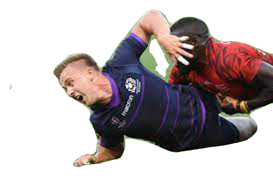

In [ ]:
from PIL import Image
from torchvision import transforms
import torch
from torch.nn import functional as F
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def extract_foreground(image_path):

    # Load DeepLabv3 model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
    model.eval()

    # Load input image
    input_image = Image.open(image_path)

    # Get original image size
    original_size = input_image.size

    # Resize input image to a specific size
    image_size = (512, 512)  # specify desired image size
    input_image = input_image.resize(image_size)

    # Convert input image to RGB format
    input_image = input_image.convert("RGB")

    # Preprocess input image
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        output_mask = model(input_batch)['out']
    output_mask = F.interpolate(output_mask, size=image_size, mode='bilinear', align_corners=False)
    output_mask = torch.argmax(output_mask, dim=1).squeeze().detach().cpu().numpy()

    # Create binary mask from output mask
    binary_mask = np.zeros_like(output_mask)
    binary_mask[output_mask == 15] = 1  # specify the class index for the foreground in DeepLabv3 (here, class index 15)

    # Overlay foreground on white canvas
    white_background = Image.new("RGB", input_image.size, (255, 255, 255))  # create a white canvas
    alpha = Image.fromarray(np.uint8(binary_mask * 255), mode="L")  # create an alpha channel from the binary mask
    foreground = Image.composite(input_image, white_background, alpha)

    # Resize foreground to original image size
    foreground = foreground.resize(original_size)

    return foreground

# Example usage
image_path = "/content/download (1).jpg"
foreground= extract_foreground(image_path)

# Save foreground as PNG
#foreground.save("foreground.png")

# Visualize white background
foreground.show()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


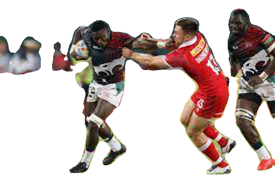

In [ ]:
# Example usage
image_path = "/content/download.jpg"
foreground= extract_foreground(image_path)


foreground.show()


In [ ]:
!pip install streamlit pillow torchvision torch --quiet

In [ ]:

%%writefile app.py
import streamlit as st

# Streamlit app

from PIL import Image
from torchvision import transforms
import torch
from torch.nn import functional as F
import numpy as np
import warnings
import io
warnings.filterwarnings('ignore')

def extract_foreground(image_path):

    # Load DeepLabv3 model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
    model.eval()

    # Load input image
    input_image = Image.open(image_path)

    # Get original image size
    original_size = input_image.size

    # Resize input image to a specific size
    image_size = (512, 512)  # specify desired image size
    input_image = input_image.resize(image_size)

    # Convert input image to RGB format
    input_image = input_image.convert("RGB")

    # Preprocess input image
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        output_mask = model(input_batch)['out']
    output_mask = F.interpolate(output_mask, size=image_size, mode='bilinear', align_corners=False)
    output_mask = torch.argmax(output_mask, dim=1).squeeze().detach().cpu().numpy()

    # Create binary mask from output mask
    binary_mask = np.zeros_like(output_mask)
    binary_mask[output_mask == 15] = 1  # specify the class index for the foreground in DeepLabv3 (here, class index 15)

    # Overlay foreground on white canvas
    white_background = Image.new("RGB", input_image.size, (255, 255, 255))  # create a white canvas
    alpha = Image.fromarray(np.uint8(binary_mask * 255), mode="L")  # create an alpha channel from the binary mask
    foreground = Image.composite(input_image, white_background, alpha)

    # Resize foreground to original image size
    foreground = foreground.resize(original_size)

    return foreground

# Define CSS styles
PAGE_STYLE = """
<style>
body {
    font-family: Arial, sans-serif;
    background-color: #f8f9fa;
    margin: 0;
    padding: 0;
}

.container {
    max-width: 800px;
    margin: 0 auto;
    padding: 20px;
}

.title {
    font-size: 24px;
    font-weight: bold;
    margin-bottom: 20px;
}

.image {
    max-width: 100%;
    height: auto;
    margin-bottom: 20px;
}

.downloadButton {
    background-color: #007bff;
    color: #fff;
    padding: 12px 20px;
    border: none;
    cursor: pointer;
    font-size: 16px;
    margin-top: 16px;
}
.downloadButton:hover {
    background-color: #0056b3;
}
</style>
"""

# Create Streamlit app
st.title("Foreground Extraction")

# Upload image
uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Display uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width='auto')

    # Extract foreground
    extracted_foreground = extract_foreground(uploaded_file)
    st.image(extracted_foreground, caption="Extracted Foreground", use_column_width='auto')

    # Add download button for extracted foreground
    download_buffer = io.BytesIO()
    extracted_foreground.save(download_buffer, format='PNG')  # Change format to PNG
    download_button_str = f"Download Extracted Foreground"
    st.download_button(download_button_str, download_buffer.getvalue(), file_name='extracted_foreground.png')  # Change file extension to .png


Overwriting app.py


In [ ]:
!pip install pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:

from pyngrok import ngrok

ngrok.set_auth_token("2LArVCZnMmuPMV0uYjEx4zAOSpx_6AiMAuvnRpVMQxFzSkvaE") 


!nohup streamlit run app.py --server.port 80 &
url = ngrok.connect(port = '80')
print(url)
     

INFO:pyngrok.process:Updating authtoken for default "config_path" of "ngrok_path": /usr/local/lib/python3.9/dist-packages/pyngrok/bin/ngrok
2023-04-11 15:19:37.490 Updating authtoken for default "config_path" of "ngrok_path": /usr/local/lib/python3.9/dist-packages/pyngrok/bin/ngrok


nohup: appending output to 'nohup.out'


INFO:pyngrok.ngrok:Opening tunnel named: http-80-dd6d08b6-2625-4c40-be4c-d2440ba8b43c
2023-04-11 15:19:37.911 Opening tunnel named: http-80-dd6d08b6-2625-4c40-be4c-d2440ba8b43c
INFO:pyngrok.process.ngrok:t=2023-04-11T15:19:38+0000 lvl=info msg="no configuration paths supplied"
2023-04-11 15:19:38.215 t=2023-04-11T15:19:38+0000 lvl=info msg="no configuration paths supplied"
INFO:pyngrok.process.ngrok:t=2023-04-11T15:19:38+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml
2023-04-11 15:19:38.227 t=2023-04-11T15:19:38+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml
INFO:pyngrok.process.ngrok:t=2023-04-11T15:19:38+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil
2023-04-11 15:19:38.240 t=2023-04-11T15:19:38+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil
INFO:pyngrok.process.ngrok:t=2023-04-11T15:19:38+0000 lvl=info msg="starting web service" obj=web addr

NgrokTunnel: "http://a4b8-35-194-203-172.ngrok-free.app" -> "http://localhost:80"


INFO:pyngrok.process.ngrok:t=2023-04-11T15:19:39+0000 lvl=info msg="started tunnel" obj=tunnels name=http-80-dd6d08b6-2625-4c40-be4c-d2440ba8b43c addr=http://localhost:80 url=https://a4b8-35-194-203-172.ngrok-free.app
2023-04-11 15:19:39.287 t=2023-04-11T15:19:39+0000 lvl=info msg="started tunnel" obj=tunnels name=http-80-dd6d08b6-2625-4c40-be4c-d2440ba8b43c addr=http://localhost:80 url=https://a4b8-35-194-203-172.ngrok-free.app
INFO:pyngrok.process.ngrok:t=2023-04-11T15:19:39+0000 lvl=info msg=end pg=/api/tunnels id=1c16cd5f6ba0c510 status=201 dur=395.06121ms
2023-04-11 15:19:39.291 t=2023-04-11T15:19:39+0000 lvl=info msg=end pg=/api/tunnels id=1c16cd5f6ba0c510 status=201 dur=395.06121ms
INFO:pyngrok.process.ngrok:t=2023-04-11T15:19:39+0000 lvl=info msg=start pg="/api/tunnels/http-80-dd6d08b6-2625-4c40-be4c-d2440ba8b43c (http)" id=e6809dd8483d3529
2023-04-11 15:19:39.298 t=2023-04-11T15:19:39+0000 lvl=info msg=start pg="/api/tunnels/http-80-dd6d08b6-2625-4c40-be4c-d2440ba8b43c (http)"

In [ ]:
ngrok.kill()

INFO:pyngrok.process:Killing ngrok process: 32434
2023-04-11 15:18:30.845 Killing ngrok process: 32434
